In [55]:
import os
import json


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

import keras
import tensorflow as tf
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload

In [3]:
import training_utils
reload(training_utils)

<module 'training_utils' from '/home/connor/iMaterialist_Challenge/training_utils.py'>

In [4]:
from keras import Model, Input
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, Sequence

from keras.applications import InceptionV3,inception_v3
from keras.applications import VGG16, vgg16
from sklearn.metrics import f1_score

In [5]:
labels = json.load(open('data/reformatted_train.json'))


In [6]:
y = [labels[str(x)]['labelId'] for x in range(1,20000)]
y = [[int(x) for x in a] for a in y]
classes = set()
largest = 0
for l in y:
    for num in l:
        if num not in classes:
            classes.add(num)
        if num > largest:
            largest = num
NUM_CLASSES = largest
print(largest)

228


In [17]:

def create_model2(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dense(1000, activation = 'tanh', name = 'dense1')(X)
    X = Dense(1000, activation = 'tanh', name = 'dense2')(X)

    predictions = Dense(NUM_CLASSES, activation = 'sigmoid', name = 'outlayer')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

def create_model3(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dense(1000, activation = 'tanh', name = 'dense1')(X)
    X = Dense(1000, activation = 'tanh', name = 'dense2')(X)
    X = Dense(1000, activation = 'tanh', name = 'dense3')(X)

    predictions = Dense(NUM_CLASSES, activation = 'sigmoid', name = 'outlayer')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

In [8]:
#a similar model to the other one, but uses vgg16 rather than Inception and fine tunes the last group 
#of convolutional layers

def create_finetuned_vgg16(base_layers):
    for i, layer in enumerate(base_layers.layers):
        if i not in [15,16,17]:
            layer.trainable = True
        else:
            layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dense(2000, activation = 'tanh', name = 'dense1')(X)
    X = Dense(1000, activation = 'tanh', name = 'dense2')(X)
    predictions = Dense(NUM_CLASSES, activation = 'sigmoid', name = 'outlayer')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

In [30]:
training_gen,Xval,yval = training_utils.create_sequence_and_val(labels,4000,50,inception_v3.preprocess_input)

In [31]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
iv3model2 = create_model2(inception_base)

sgd = keras.optimizers.SGD(lr = .001)
adam = keras.optimizers.Adam(lr = .01)
rmsprop = keras.optimizers.RMSprop(lr = .001)

In [32]:
iv3model2.compile(optimizer = rmsprop, loss =  'binary_crossentropy' , metrics = ['accuracy'])
iv3model2.fit_generator(training_gen,
                     epochs = 4,
                     steps_per_epoch= 100, 
                     validation_data = (Xval,yval),
                     workers = 6,
                     use_multiprocessing = True,
                     verbose = 1)

iv3model2.compile(optimizer = sgd, loss =  'binary_crossentropy' , metrics = ['accuracy'])
iv3model2.fit_generator(training_gen,
                     epochs = 2,
                     steps_per_epoch= 100, 
                     validation_data = (Xval,yval),
                     workers = 6,
                     use_multiprocessing = True,
                     verbose = 1)


Epoch 1/4
100/100 [==============================] - 82s 825ms/step - loss: 0.0997 - acc: 0.9703 - val_loss: 0.0886 - val_acc: 0.9764
Epoch 2/4
100/100 [==============================] - 74s 743ms/step - loss: 0.0899 - acc: 0.9760 - val_loss: 0.0884 - val_acc: 0.9764
Epoch 3/4
100/100 [==============================] - 74s 742ms/step - loss: 0.0893 - acc: 0.9765 - val_loss: 0.0886 - val_acc: 0.9764
Epoch 4/4
 67/100 [===================>..........] - ETA: 13s - loss: 0.0896 - acc: 0.9762

Process ForkPoolWorker-51:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-50:
Process ForkPoolWorker-49:
Process ForkPoolWorker-53:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/connor/anaconda3/lib/python3.6/multiprocessing/pr

Epoch 1/4


KeyboardInterrupt: 

/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


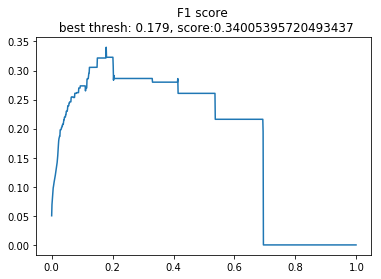

In [33]:
eval_model(iv3model2,Xval,yval)

In [34]:
training_gen,Xval,yval = training_utils.create_sequence_and_val(labels,4000,50,inception_v3.preprocess_input)

In [35]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
iv3model3 = create_model3(inception_base)

sgd = keras.optimizers.SGD(lr = .001)
adam = keras.optimizers.Adam(lr = .01)
rmsprop3 = keras.optimizers.RMSprop(lr = .001)

In [36]:
iv3model3.compile(optimizer = adam, loss =  'binary_crossentropy' , metrics = ['accuracy'])
iv3model3.fit_generator(training_gen,
                     epochs = 4,
                     steps_per_epoch= 100, 
                     validation_data = (Xval,yval),
                     workers = 6,
                     use_multiprocessing = True,
                     verbose = 1)

iv3model3.compile(optimizer = sgd, loss =  'binary_crossentropy' , metrics = ['accuracy'])
iv3model3.fit_generator(training_gen,
                     epochs = 2,
                     steps_per_epoch= 100, 
                     validation_data = (Xval,yval),
                     workers = 6,
                     use_multiprocessing = True,
                     verbose = 1)


Epoch 1/4
100/100 [==============================] - 85s 845ms/step - loss: 0.1518 - acc: 0.9633 - val_loss: 0.1341 - val_acc: 0.9765
Epoch 2/4
100/100 [==============================] - 75s 753ms/step - loss: 0.1463 - acc: 0.9747 - val_loss: 0.1534 - val_acc: 0.9741
Epoch 3/4
100/100 [==============================] - 75s 754ms/step - loss: 0.1583 - acc: 0.9750 - val_loss: 0.1623 - val_acc: 0.9752
Epoch 4/4
100/100 [==============================] - 76s 758ms/step - loss: 0.1637 - acc: 0.9746 - val_loss: 0.1703 - val_acc: 0.9744
Epoch 1/2
100/100 [==============================] - 81s 813ms/step - loss: 0.1696 - acc: 0.9744 - val_loss: 0.1695 - val_acc: 0.9744
Epoch 2/2
100/100 [==============================] - 72s 718ms/step - loss: 0.1691 - acc: 0.9745 - val_loss: 0.1688 - val_acc: 0.9744


/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


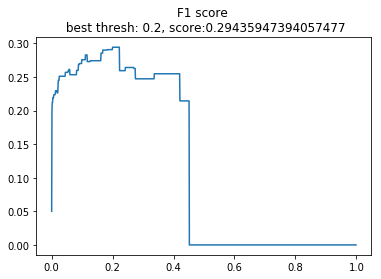

In [37]:
eval_model(iv3model3,Xval,yval)

In [40]:
training_gen2,Xval2,yval2 = training_utils.create_sequence_and_val(labels,2000,50,vgg16.preprocess_input)

In [41]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
#vggmodel = create_finetuned_vgg16(vgg_base)
vggmodel = create_model3(vgg_base)

In [42]:
adam = keras.optimizers.Adam(lr = .01)
vggmodel.compile(optimizer = adam, loss =  keras.losses.binary_crossentropy , metrics = ['accuracy'])
vggmodel.fit_generator(training_gen2,
                     epochs = 4,
                     steps_per_epoch= 100, 
                     validation_data = (Xval2,yval2),
                     workers =6,
                     use_multiprocessing = True,
                     verbose = 1)

sgd = keras.optimizers.SGD(lr = .001)
vggmodel.compile(optimizer = sgd, loss =  keras.losses.binary_crossentropy , metrics = ['accuracy'])
vggmodel.fit_generator(training_gen2,
                     epochs = 2,
                     steps_per_epoch= 100, 
                     validation_data = (Xval2,yval2),
                     workers =6,
                     use_multiprocessing = True,
                     verbose = 1)


Epoch 1/4
100/100 [==============================] - 157s 2s/step - loss: 0.1375 - acc: 0.9691 - val_loss: 0.1313 - val_acc: 0.9736
Epoch 2/4
100/100 [==============================] - 145s 1s/step - loss: 0.1370 - acc: 0.9750 - val_loss: 0.1432 - val_acc: 0.9765
Epoch 3/4
100/100 [==============================] - 145s 1s/step - loss: 0.1434 - acc: 0.9751 - val_loss: 0.1431 - val_acc: 0.9765
Epoch 4/4
  1/100 [..............................] - ETA: 1:41 - loss: 0.1328 - acc: 0.9774

ResourceExhaustedError: OOM when allocating tensor with shape[50,64,224,224]
	 [[Node: block1_conv2_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](block1_conv1_1/Relu, block1_conv2_1/kernel/read)]]
	 [[Node: metrics_12/acc/Mean_1/_25097 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_293_metrics_12/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'block1_conv2_1/convolution', defined at:
  File "/home/connor/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/connor/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/connor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-a9d4ce12ce2d>", line 1, in <module>
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py", line 117, in VGG16
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 639, in convolution
    op=op)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 308, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 631, in op
    name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/connor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[50,64,224,224]
	 [[Node: block1_conv2_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](block1_conv1_1/Relu, block1_conv2_1/kernel/read)]]
	 [[Node: metrics_12/acc/Mean_1/_25097 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_293_metrics_12/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
eval_model(vggmodel,X_val2,y_val)

In [14]:
def eval_model(model,X_val,y_val):
    preds = model.predict(X_val)
    thresholds = np.linspace(0,1,1000,endpoint=False)
    f1s = []
    for t in thresholds:
        y_hat = preds > t
        f1 = f1_score(y_val,y_hat,average = 'micro')
        f1s.append(f1)
    plotf1s(thresholds,f1s)

In [15]:
def plotf1s(thresholds,f1s):
    fig, ax = plt.subplots()
    ax.plot(thresholds,f1s)
    best = np.argmax(f1s)
    ax.set_title("F1 score \n best thresh: {}, score:{}".format(thresholds[best],f1s[best]))
    plt.show()

In [73]:
preds = iv3model.predict(Xval)

In [90]:
yval.sum()/(2000*228)


0.025732456140350878

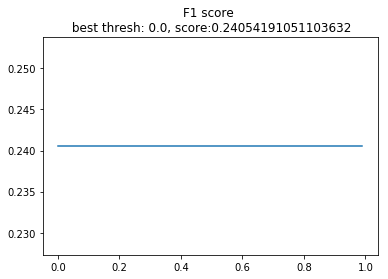

In [32]:
eval_model(vggmodel,Xval2,yval2)

/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


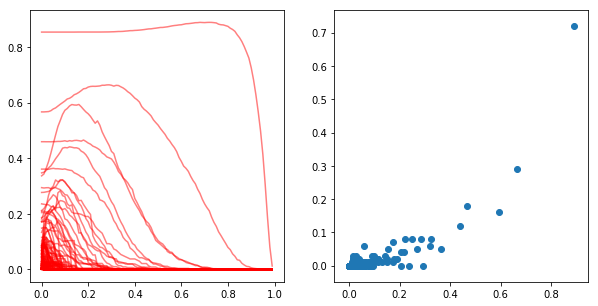

In [112]:
def find_best_f1(true_col,pred_col,ax):
    
    f1s = []
    thresholds = np.linspace(0,1,100,endpoint=False)
    for t in thresholds:
        col_hat = pred_col > t
        f1 = f1_score(true_col.flatten(),col_hat.flatten())
        f1s.append(f1)
    ax.plot(thresholds,f1s,alpha = .5,color = 'r')
    #print(f1s)
    if np.all(f1s == 0.0):
        return .1, None
    else:
        best = np.argmax(f1s)
        #print(thresholds[best], f1s[best])
        return thresholds[best], f1s[best]

optimal_ts = np.zeros((preds.shape))
fig,ax = plt.subplots(1,2, figsize = (10,5))
fs, ts = [], []
for c in range(0,preds.shape[1]):
    t,f = find_best_f1(yval[:,c],preds[:,c],ax[0])
    fs.append(f)
    ts.append(t)
    optimal_ts[:,c] = t
ax[1].scatter(fs,ts)
plt.show()

In [113]:
y_hat = np.zeros(preds.shape)
for c in range(0,preds.shape[1]):
    t = optimal_ts[0,c] 
    y_hat[:,c] = preds[:,c] > t
    #print("{}   {}   {}".format(c,t,f1_score(yval[:,c],y_hat[:,c])))
f1 = f1_score(yval,y_hat,average = 'micro')
print(f1)

0.04513385543569084


In [101]:
y_hat = preds > .15    
f1 = f1_score(yval,y_hat,average = 'micro')
print(f1)

0.3735322119961917


In [91]:
f1_score(yval[:,10],preds[:,10]> .06)

/home/connor/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [56]:
def evaluate_test_set(model,img_folder,preprocessing_func,threshold):
    imgs = os.listdir(img_folder)
    entries = []
    for im in tqdm(imgs):
        id_ = im[:-4]
        img = image.load_img('{}/{}'.format(img_folder,im),grayscale=False,target_size=(224,224,3))
        image.img_to_array(img)
        x = image.img_to_array(img)
        x = x.reshape((1,224,224,3))
        x = preprocessing_func(x)
        pred = model.predict(x)
        preds = [i+1 for i,p in enumerate(pred.flatten()) if p > threshold]
        entry = [id_].extend(preds)
        entries.append(entry)
    return entries
    

In [ ]:
entries = evaluate_test_set(iv3model2, 'data/test_data', inception_v3.preprocess_input, .179)

 18%|█▊        | 6958/39706 [05:22<25:18, 21.56it/s]